In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", None, "display.max_columns", None)
%matplotlib inline

Aim of this notebook is to compare the project Tinytag data (PHR, Sam Houston, and UTK Tox) with the local climatological data (LCD) since the project data contained questionable temperature and relative humidity values (e.g., 0% relative humidity, negative temp values in spring months).

Key takeaways:
* The 0% relative humidity present in the project data never occurs in the LCD data.
* The questionable negative temp. values of the project data were also present in the LCD data. 
* Based on the distributions of absolute_value(project_temp - lcd_temp) and absolute_value(project_hum - lcd_hum), decide on a value when the project data value should be replaced with the LCD data value, or vice versa.

In [2]:
# Import project and lcd data
project_df = pd.read_pickle('./data/project_data_merged_processed.pkl')
print(project_df.shape)
display(project_df.head())

lcd_df = pd.read_pickle('./data/LCD/lcd_hourly.pkl')
print(lcd_df.shape)
display(lcd_df.head())

(43411, 3)


,date_time,temp_C,hum_RH
0,2014-03-14 17:31:00,17.16219,23.475
1,2014-03-14 18:31:00,16.50121,22.769
2,2014-03-14 19:31:00,15.84665,25.357
3,2014-03-14 20:31:00,15.60761,25.122
4,2014-03-14 21:31:00,15.47507,25.827


(107340, 3)


,date_time,HourlyDryBulbTemperature,HourlyRelativeHumidity
0,2011-01-01 00:00:00,12.033333,90.333333
1,2011-01-01 01:00:00,10.575000,92.250000
2,2011-01-01 02:00:00,10.600000,92.000000
3,2011-01-01 03:00:00,10.425000,92.000000
4,2011-01-01 04:00:00,10.340000,92.800000


In [3]:
display(project_df.info())
display(lcd_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43411 entries, 0 to 17531
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  43411 non-null  datetime64[ns]
 1   temp_C     43411 non-null  float64       
 2   hum_RH     43411 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107340 entries, 0 to 107339
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   date_time                 107340 non-null  datetime64[ns]
 1   HourlyDryBulbTemperature  107340 non-null  float64       
 2   HourlyRelativeHumidity    107340 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.3 MB


None

In [4]:
# create date and hour columns 
project_df['date'] = pd.to_datetime(project_df['date_time']).dt.date
project_df['hour'] = pd.to_datetime(project_df['date_time']).dt.hour
display(project_df.head())

lcd_df['date'] = pd.to_datetime(lcd_df['date_time']).dt.date
lcd_df['hour'] = pd.to_datetime(lcd_df['date_time']).dt.hour
display(lcd_df.head())

,date_time,temp_C,hum_RH,date,hour
0,2014-03-14 17:31:00,17.16219,23.475,2014-03-14,17
1,2014-03-14 18:31:00,16.50121,22.769,2014-03-14,18
2,2014-03-14 19:31:00,15.84665,25.357,2014-03-14,19
3,2014-03-14 20:31:00,15.60761,25.122,2014-03-14,20
4,2014-03-14 21:31:00,15.47507,25.827,2014-03-14,21


,date_time,HourlyDryBulbTemperature,HourlyRelativeHumidity,date,hour
0,2011-01-01 00:00:00,12.033333,90.333333,2011-01-01,0
1,2011-01-01 01:00:00,10.575000,92.250000,2011-01-01,1
2,2011-01-01 02:00:00,10.600000,92.000000,2011-01-01,2
3,2011-01-01 03:00:00,10.425000,92.000000,2011-01-01,3
4,2011-01-01 04:00:00,10.340000,92.800000,2011-01-01,4


In [5]:
# left join data on date and hour 
joined_df = pd.merge(project_df, lcd_df, how='left', on=['date', 'hour'])
display(joined_df.head())
joined_df.shape

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity
0,2014-03-14 17:31:00,17.16219,23.475,2014-03-14,17,2014-03-14 17:00:00,16.1,23.0
1,2014-03-14 18:31:00,16.50121,22.769,2014-03-14,18,2014-03-14 18:00:00,15.6,24.0
2,2014-03-14 19:31:00,15.84665,25.357,2014-03-14,19,2014-03-14 19:00:00,15.3,24.5
3,2014-03-14 20:31:00,15.60761,25.122,2014-03-14,20,2014-03-14 20:00:00,14.4,32.0
4,2014-03-14 21:31:00,15.47507,25.827,2014-03-14,21,2014-03-14 21:00:00,13.3,39.0


(43411, 8)

In [6]:
joined_df.describe(datetime_is_numeric=True)

,date_time_x,temp_C,hum_RH,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity
count,43411,43411.000000,43411.000000,43411.000000,43404,43404.000000,43404.000000
mean,2018-05-30 09:41:01.694501632,16.138753,72.003038,11.500587,2018-05-30 12:58:19.225878016,16.451003,67.907537
min,2014-03-14 17:31:00,-12.285000,0.000000,0.000000,2014-03-14 17:00:00,-13.300000,12.000000
25%,2016-04-03 12:31:00,9.918660,57.100000,6.000000,2016-04-03 15:45:00,10.000000,52.000000
50%,2019-04-30 17:19:00,17.402000,78.700000,12.000000,2019-04-30 18:00:00,17.500000,70.000000
75%,2020-03-20 03:39:00,22.651000,95.800000,17.000000,2020-03-20 05:15:00,23.300000,85.000000
max,2021-08-13 07:44:00,42.184000,100.000000,23.000000,2021-08-13 07:00:00,36.100000,100.000000
std,NaN,8.613110,27.666212,6.920100,NaN,8.972394,19.750960


## Density plots

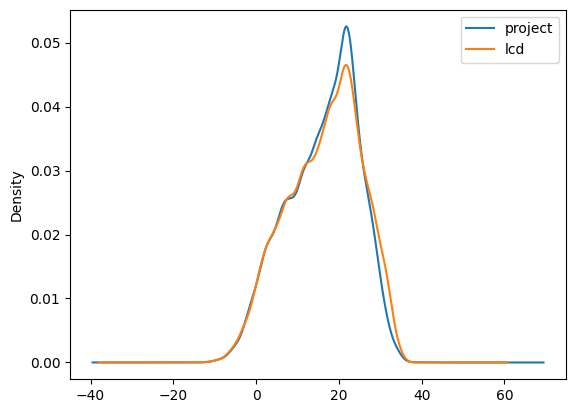

In [7]:
# temp density plot
df = pd.DataFrame({'project': joined_df['temp_C'], 'lcd': joined_df['HourlyDryBulbTemperature']})
ax = df.plot.kde()

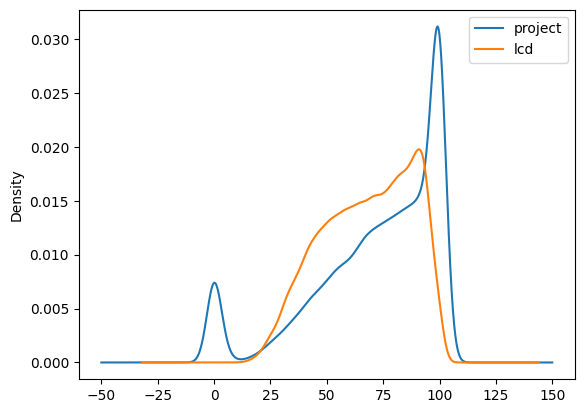

In [8]:
# humidity density plot
df = pd.DataFrame({'project': joined_df['hum_RH'], 'lcd': joined_df['HourlyRelativeHumidity']})
ax = df.plot.kde()

## Time series line plots
Since the project data has time gaps, the different timeframes will be visualized seperately.

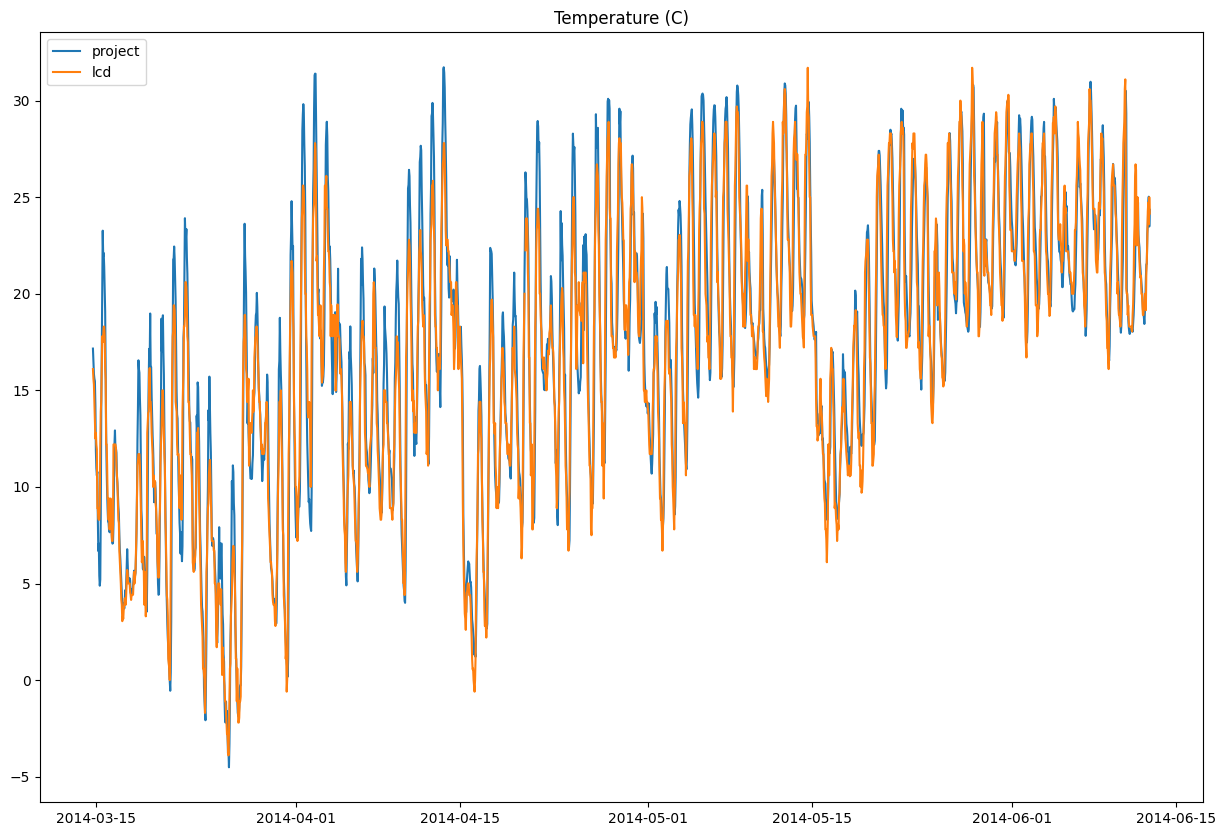

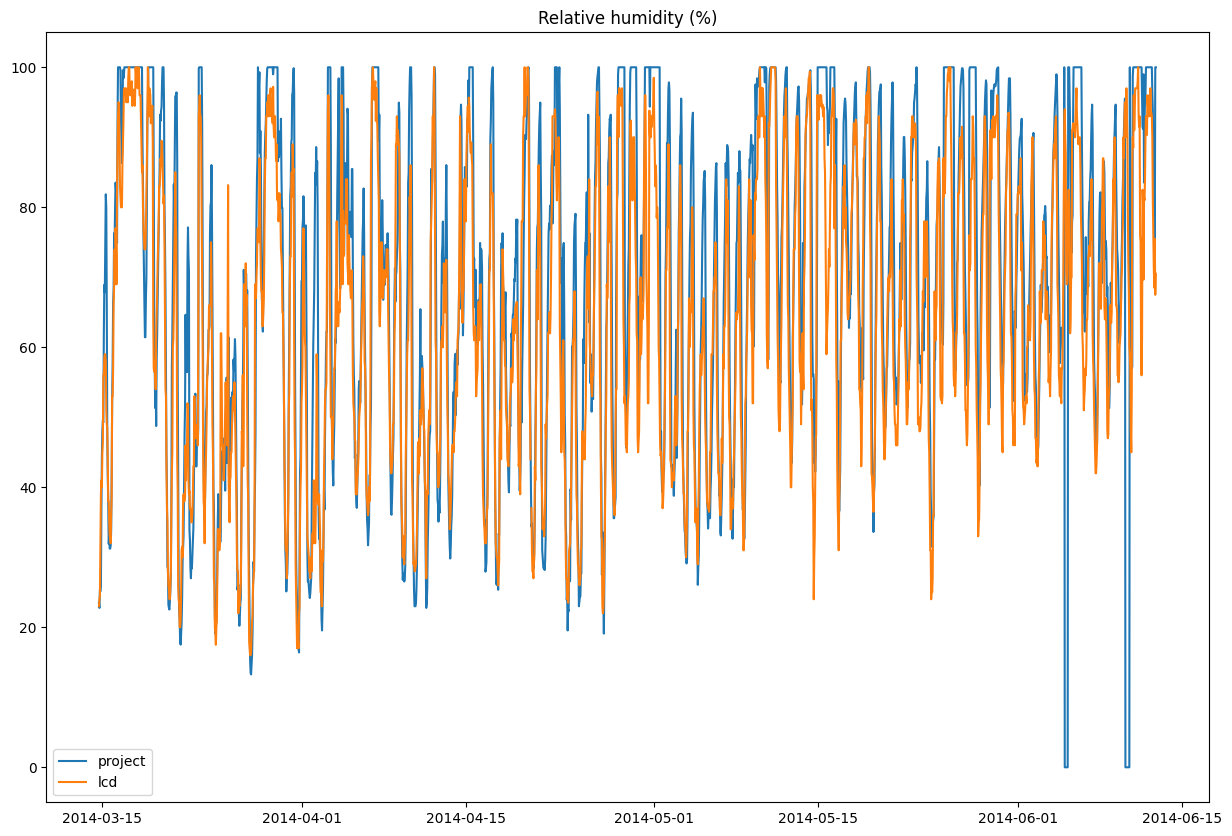

In [9]:
joined_2014_df = joined_df.loc[(joined_df['date_time_x'] >= '2014-01-01')
                     & (joined_df['date_time_x'] < '2015-01-01')].copy()
joined_2014_df.describe(datetime_is_numeric=True)


fig = plt.figure(figsize=(15,10))
plt.plot(joined_2014_df.date_time_x, joined_2014_df.temp_C, label='project')
plt.plot(joined_2014_df.date_time_x, joined_2014_df.HourlyDryBulbTemperature, label='lcd')
plt.legend()
plt.title('Temperature (C)')
plt.show()

fig = plt.figure(figsize=(15,10))
plt.plot(joined_2014_df.date_time_x, joined_2014_df.hum_RH, label='project')
plt.plot(joined_2014_df.date_time_x, joined_2014_df.HourlyRelativeHumidity, label='lcd')
plt.legend()
plt.title('Relative humidity (%)')
plt.show()

In [10]:
joined_2014_df[(joined_2014_df.temp_C < 0) & (joined_2014_df.HourlyDryBulbTemperature > 0)]

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity
158,2014-03-21 07:31:00,-0.55280,96.399,2014-03-21,7,2014-03-21 07:00:00,1.4,76.0
227,2014-03-24 04:31:00,-0.37679,76.290,2014-03-24,4,2014-03-24 04:00:00,0.3,66.0
231,2014-03-24 08:31:00,-0.16596,78.794,2014-03-24,8,2014-03-24 08:00:00,3.3,60.0
280,2014-03-26 09:31:00,-0.93547,51.574,2014-03-26,9,2014-03-26 09:00:00,0.6,42.0
295,2014-03-27 00:31:00,-1.01232,59.830,2014-03-27,0,2014-03-27 00:00:00,0.6,43.0


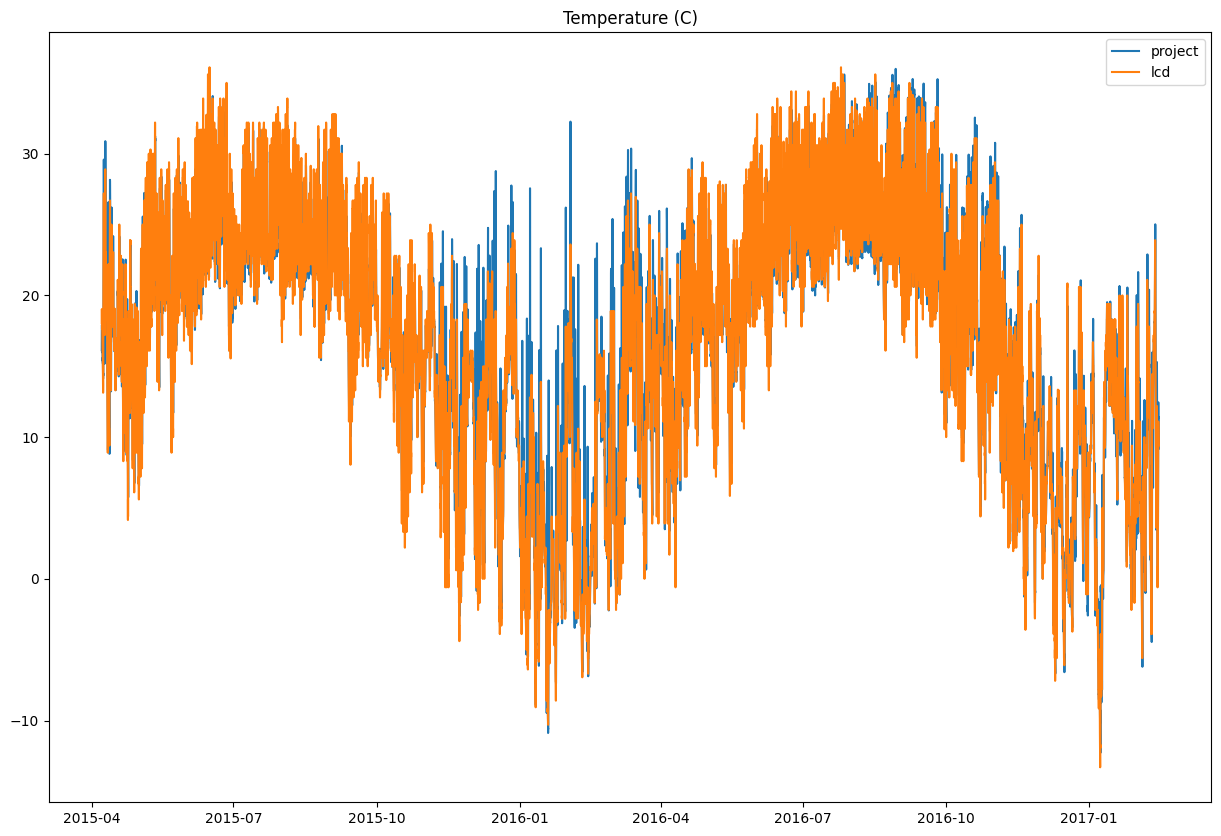

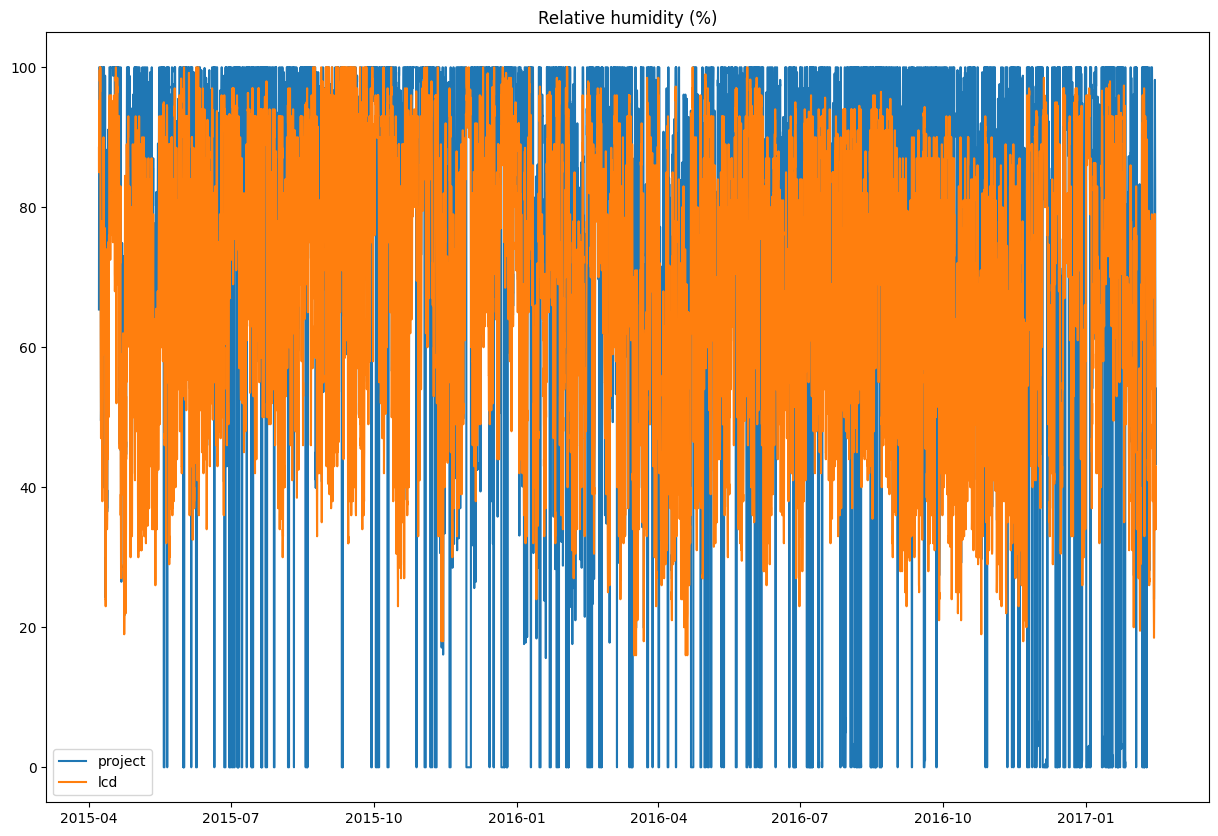

In [11]:
joined_2015_2017_df = joined_df.loc[(joined_df['date_time_x'] >= '2015-01-01')
                     & (joined_df['date_time_x'] < '2018-01-01')].copy()
joined_2015_2017_df.describe(datetime_is_numeric=True)

fig = plt.figure(figsize=(15,10))
plt.plot(joined_2015_2017_df.date_time_x, joined_2015_2017_df.temp_C, label='project')
plt.plot(joined_2015_2017_df.date_time_x, joined_2015_2017_df.HourlyDryBulbTemperature, label='lcd')
plt.legend()
plt.title('Temperature (C)')
plt.show()

fig = plt.figure(figsize=(15,10))
plt.plot(joined_2015_2017_df.date_time_x, joined_2015_2017_df.hum_RH, label='project')
plt.plot(joined_2015_2017_df.date_time_x, joined_2015_2017_df.HourlyRelativeHumidity, label='lcd')
plt.legend()
plt.title('Relative humidity (%)')
plt.show()

In [13]:
joined_2015_2017_df[(joined_2015_2017_df.temp_C < 0) & (joined_2015_2017_df.HourlyDryBulbTemperature > 0)].head()

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity
7681,2015-11-23 09:01:00,-2.575,100.0,2015-11-23,9,2015-11-23 09:00:00,0.60,75.0
7682,2015-11-23 10:01:00,-2.046,100.0,2015-11-23,10,2015-11-23 10:00:00,1.95,66.0
7683,2015-11-23 11:01:00,-0.627,93.8,2015-11-23,11,2015-11-23 11:00:00,4.40,45.0
7704,2015-11-24 08:01:00,-1.273,100.0,2015-11-24,8,2015-11-24 08:00:00,1.10,75.0
7705,2015-11-24 09:01:00,-1.261,100.0,2015-11-24,9,2015-11-24 09:00:00,3.90,62.0


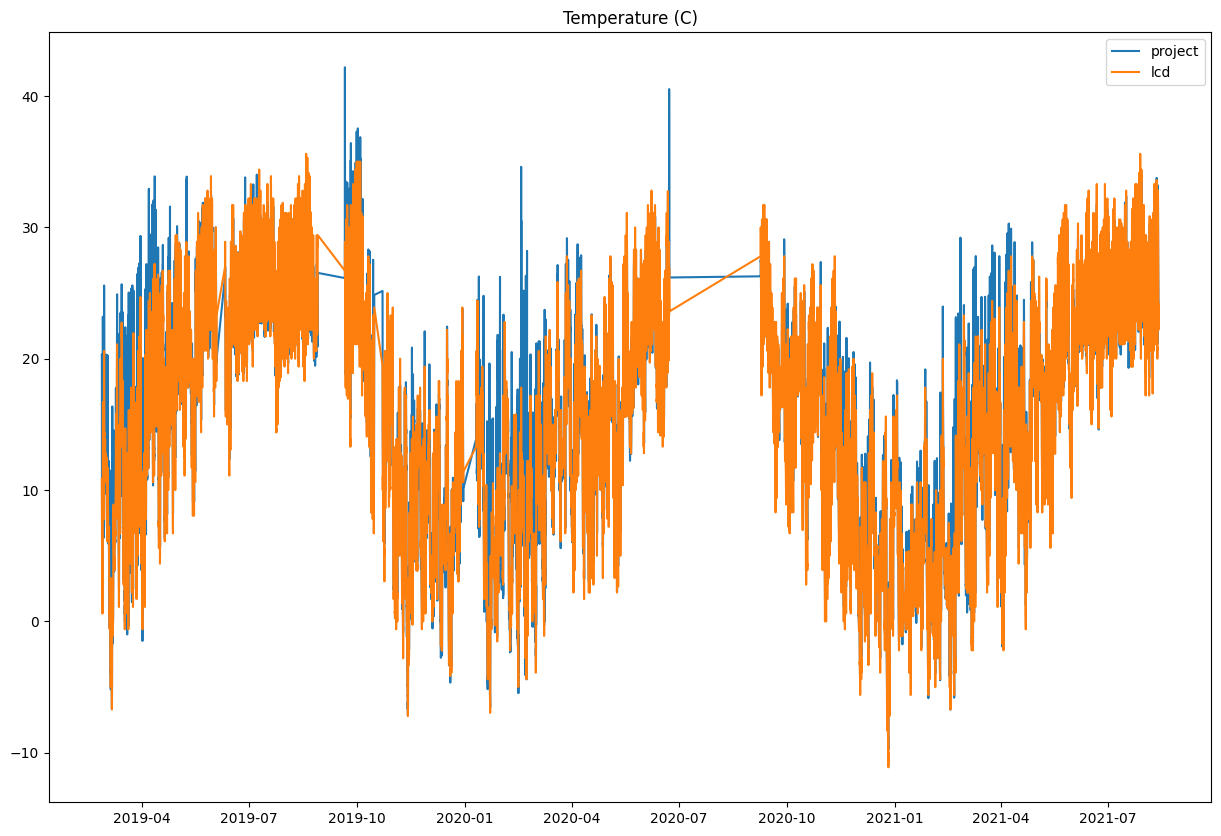

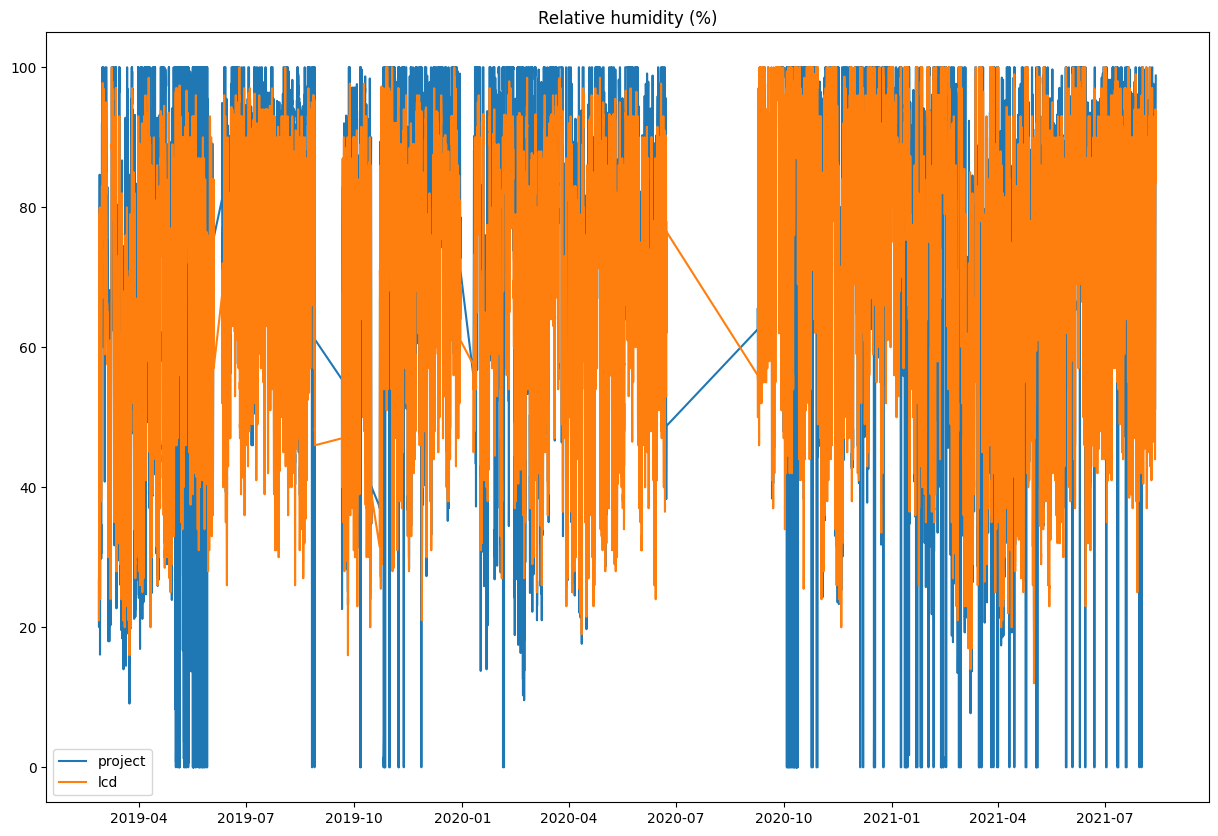

In [14]:
joined_2019_plus_df = joined_df.loc[(joined_df['date_time_x'] >= '2019-01-01')].copy()
joined_2019_plus_df.describe(datetime_is_numeric=True)

fig = plt.figure(figsize=(15,10))
plt.plot(joined_2019_plus_df.date_time_x, joined_2019_plus_df.temp_C, label='project')
plt.plot(joined_2019_plus_df.date_time_x, joined_2019_plus_df.HourlyDryBulbTemperature, label='lcd')
plt.legend()
plt.title('Temperature (C)')
plt.show()

fig = plt.figure(figsize=(15,10))
plt.plot(joined_2019_plus_df.date_time_x, joined_2019_plus_df.hum_RH, label='project')
plt.plot(joined_2019_plus_df.date_time_x, joined_2019_plus_df.HourlyRelativeHumidity, label='lcd')
plt.legend()
plt.title('Relative humidity (%)')
plt.show()

In [15]:
joined_2019_plus_df[(joined_2019_plus_df.temp_C < 0) & (joined_2019_plus_df.HourlyDryBulbTemperature > 0)].head()

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity
18625,2019-03-04 18:47:00,-0.045,69.3,2019-03-04,18,2019-03-04 18:00:00,0.6,66.0
18650,2019-03-05 19:47:00,-0.075,36.0,2019-03-05,19,2019-03-05 19:00:00,0.3,37.0
18674,2019-03-06 19:47:00,-0.794,56.0,2019-03-06,19,2019-03-06 19:00:00,0.3,39.0
19040,2019-03-17 07:46:00,-0.020,80.4,2019-03-17,7,2019-03-17 07:00:00,0.8,74.5
19131,2019-03-19 05:31:00,-0.131,69.3,2019-03-19,5,2019-03-19 05:00:00,0.6,56.0


In [16]:
joined_2019_plus_df[(joined_2019_plus_df.hum_RH == 0)].head()

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity
21810,2019-05-02 04:19:00,18.690,0.0,2019-05-02,4,2019-05-02 04:00:00,19.150000,88.5
21906,2019-05-03 12:19:00,19.114,0.0,2019-05-03,12,2019-05-03 12:00:00,26.100000,65.0
21981,2019-05-04 13:19:00,19.302,0.0,2019-05-04,13,2019-05-04 13:00:00,19.066667,87.0
22014,2019-05-05 00:19:00,18.687,0.0,2019-05-05,0,2019-05-05 00:00:00,17.800000,96.0
22020,2019-05-05 02:19:00,17.498,0.0,2019-05-05,2,2019-05-05 02:00:00,17.200000,93.0


## Temp./Hum. difference analysis
Analyze the distribution of 
1. absolute_value(temp_C - HourlyDryBulbTemperature)
2. absolute_value(hum_RH - HourlyRelativeHumidity)

In [18]:
joined_df['temp_diff'] = (joined_df.temp_C - joined_df.HourlyDryBulbTemperature).abs()
joined_df['hum_diff'] = (joined_df.hum_RH - joined_df.HourlyRelativeHumidity).abs()
joined_df.head()

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity,temp_diff,hum_diff
0,2014-03-14 17:31:00,17.16219,23.475,2014-03-14,17,2014-03-14 17:00:00,16.1,23.0,1.06219,0.475
1,2014-03-14 18:31:00,16.50121,22.769,2014-03-14,18,2014-03-14 18:00:00,15.6,24.0,0.90121,1.231
2,2014-03-14 19:31:00,15.84665,25.357,2014-03-14,19,2014-03-14 19:00:00,15.3,24.5,0.54665,0.857
3,2014-03-14 20:31:00,15.60761,25.122,2014-03-14,20,2014-03-14 20:00:00,14.4,32.0,1.20761,6.878
4,2014-03-14 21:31:00,15.47507,25.827,2014-03-14,21,2014-03-14 21:00:00,13.3,39.0,2.17507,13.173


In [21]:
joined_df.describe()

,temp_C,hum_RH,hour,HourlyDryBulbTemperature,HourlyRelativeHumidity,temp_diff,hum_diff
count,43411.000000,43411.000000,43411.000000,43404.000000,43404.000000,43404.000000,43404.000000
mean,16.138753,72.003038,11.500587,16.451003,67.907537,1.635612,16.914513
std,8.613110,27.666212,6.920100,8.972394,19.750960,1.627916,21.039036
min,-12.285000,0.000000,0.000000,-13.300000,12.000000,0.000000,0.000000
25%,9.918660,57.100000,6.000000,10.000000,52.000000,0.487000,5.000000
50%,17.402000,78.700000,12.000000,17.500000,70.000000,1.125000,10.300000
75%,22.651000,95.800000,17.000000,23.300000,85.000000,2.230000,19.000000
max,42.184000,100.000000,23.000000,36.100000,100.000000,20.715680,100.000000


In [26]:
# when temp_diff >= 3
joined_df[joined_df.temp_diff >= 10].head(10)

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity,temp_diff,hum_diff
6915,2015-10-22 11:01:00,10.616,100.0,2015-10-22,11,2015-10-22 11:00:00,21.10,47.0,10.484,53.0
7952,2015-12-04 16:01:00,21.881,25.6,2015-12-04,16,2015-12-04 16:00:00,10.25,44.5,11.631,18.9
7976,2015-12-05 16:01:00,23.563,26.5,2015-12-05,16,2015-12-05 16:00:00,12.25,42.5,11.313,16.0
8240,2015-12-16 16:01:00,28.777,31.9,2015-12-16,16,2015-12-16 16:00:00,18.05,52.0,10.727,20.1
8720,2016-01-05 16:01:00,18.368,17.6,2016-01-05,16,2016-01-05 16:00:00,4.15,36.0,14.218,18.4
8744,2016-01-06 16:01:00,17.155,17.8,2016-01-06,16,2016-01-06 16:00:00,6.10,33.0,11.055,15.2
8768,2016-01-07 16:01:00,27.560,18.6,2016-01-07,16,2016-01-07 16:00:00,12.20,42.0,15.360,23.4
8912,2016-01-13 16:01:00,16.149,18.4,2016-01-13,16,2016-01-13 16:00:00,4.15,25.5,11.999,7.1
8936,2016-01-14 16:01:00,23.331,28.5,2016-01-14,16,2016-01-14 16:00:00,12.80,37.0,10.531,8.5
9032,2016-01-18 16:01:00,8.683,23.8,2016-01-18,16,2016-01-18 16:00:00,-4.40,33.0,13.083,9.2


In [28]:
# when hum_diff >= 10
joined_df[joined_df.hum_diff >= 10].sample(10)

,date_time_x,temp_C,hum_RH,date,hour,date_time_y,HourlyDryBulbTemperature,HourlyRelativeHumidity,temp_diff,hum_diff
17637,2017-01-11 05:01:00,9.246,0.0,2017-01-11,5,2017-01-11 05:00:00,9.233333,96.666667,0.012667,96.666667
25313,2019-07-25 13:49:00,24.524,54.6,2019-07-25,13,2019-07-25 13:00:00,27.750000,32.500000,3.226000,22.100000
15526,2016-10-15 06:01:00,15.613,100.0,2016-10-15,6,2016-10-15 06:00:00,15.000000,87.000000,0.613000,13.000000
16102,2016-11-08 06:01:00,7.803,94.4,2016-11-08,6,2016-11-08 06:00:00,7.200000,77.000000,0.603000,17.400000
7077,2015-10-29 05:01:00,15.073,100.0,2015-10-29,5,2015-10-29 05:00:00,15.000000,90.000000,0.073000,10.000000
3554,2015-06-04 10:01:00,18.509,100.0,2015-06-04,10,2015-06-04 10:00:00,23.350000,61.000000,4.841000,39.000000
10001,2016-02-28 01:01:00,2.523,92.3,2016-02-28,1,2016-02-28 01:00:00,5.550000,59.000000,3.027000,33.300000
14785,2016-09-14 09:01:00,22.360,100.0,2016-09-14,9,2016-09-14 09:00:00,27.800000,55.000000,5.440000,45.000000
14815,2016-09-15 15:01:00,32.899,38.0,2016-09-15,15,2016-09-15 15:00:00,33.900000,25.000000,1.001000,13.000000
18435,2017-02-13 11:01:00,4.573,54.3,2017-02-13,11,2017-02-13 11:00:00,9.400000,26.000000,4.827000,28.300000
